# PA004 - HEALTH INSURANCE CROS-SELL

## Final Version Cycle 1

## 0 - IMPORTS AND FUNCTIONS

In [1]:
# Data Analysis and Data Manipulation Libraries
import pandas                  as pd
import numpy                   as np
import seaborn                 as sns
import scikitplot              as skplt
import matplotlib.pyplot       as plt
import inflection
from ydata_profiling           import ProfileReport 

# Machine Learning Models
import optuna
import lightgbm                as lgbm
from catboost                  import CatBoostClassifier
from xgboost                   import XGBClassifier
from sklearn.neighbors         import KNeighborsClassifier

from sklearn                   import model_selection as ms
from sklearn.model_selection   import  KFold, StratifiedKFold
from sklearn                   import pipeline

# Metrics and Performance
from sklearn.metrics           import precision_score, roc_auc_score, roc_curve,auc, recall_score
from sklearn.metrics           import precision_recall_curve

# Data Transformer
from feature_engine.encoding       import CountFrequencyEncoder

# Dysplay
%matplotlib inline
from IPython.core.display    import HTML
from IPython.display         import Image

import warnings
warnings.filterwarnings( 'ignore' )

### 0.1 - HELPER FUNCTIONS

In [2]:
def ml_performance( model_name, precision_atK, recall_atK):
        
        return pd.DataFrame( {'Model Name': model_name,
                              'Precision_at_K': precision_atK,
                              'Recall_at_K': recall_atK}, index=[0] )

def precision_at_k_cv(y_true, proba_predictions, k):
    # Ordenar as probabilidades estimadas em ordem decrescente
    sorted_indices = np.argsort(proba_predictions[:, 1])[::-1]
    top_k_indices = sorted_indices[:k]
    
    # Converter as probabilidades em rótulos binários usando o top k
    binary_predictions = np.zeros_like(y_true)
    binary_predictions[top_k_indices] = 1
    
    # Calcular a precisão at k
    precision_at_k = precision_score(y_true, binary_predictions)
    
    return precision_at_k

def recall_at_k_cv(y_true, proba_predictions, k):
    # Ordenar as probabilidades estimadas em ordem decrescente
    sorted_indices = np.argsort(proba_predictions[:, 1])[::-1]
    top_k_indices = sorted_indices[:k]
    
    # Converter as probabilidades em rótulos binários usando o top k
    binary_predictions = np.zeros_like(y_true)
    binary_predictions[top_k_indices] = 1
    
    # Calcular a precisão at k
    recall_at_k = recall_score(y_true, binary_predictions)
    
    return recall_at_k

def cross_validation(kfold, modelName, model, X, y, at_k):
    
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    recall_list = []
    cv_performance = {}
    
    for train_cv,val_cv in fold.split(X, y):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = X.iloc[train_cv]
        x_train_fold = x_train_fold
        
        y_train_fold = y.iloc[train_cv]
        
        # validation data
        x_val_fold = X.iloc[val_cv]
        x_val_fold = x_val_fold
        
        y_val_fold = y.iloc[val_cv]
        
        # fitting the model
        model_fitted = model.fit(x_train_fold,y_train_fold)
        
        # getting the prediction probability
        x_val_fold['response'] = y_val_fold
        val_scored = prediction_score(model_fitted, x_val_fold)
        
        # Getting precision and recall at k
        precision = val_scored.loc[at_k, 'precision_at_k']
        recall = val_scored.loc[at_k, 'recall_at_k']
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    # calculating the mean and std performance of all kfolds
    precision_cv = np.round(np.mean(precision_list),4).astype(float)
    std_precision_cv = '+/-' + np.round(np.std(precision_list),4).astype(str)
    recall_cv = np.round(np.mean(recall_list),4).astype(float)
    std_recall_cv = ' +/- ' + np.round(np.std(recall_list),4).astype(str)
        
    cv_performance[modelName] = [precision_cv, std_precision_cv, recall_cv, std_recall_cv]
    model_performance_cv = pd.DataFrame(cv_performance, index=['precision_at_k', 'std_precision', 'recall_at_k', 'std_recall'])

    return model_performance_cv

def prediction_score(model, data):
    # Separating train and validation dataset for each kfold
    x_train = data.drop(columns=['response'])
    y_train = data['response']
    
    # prediction probability (score)
    yhat_proba = model.predict_proba(x_train)[:, 1].tolist()
    
    # merging score to dataset
    data_scored = data.copy()
    data_scored['score'] = yhat_proba
    
    # sort
    data_scored = data_scored.sort_values('score', ascending=False)
    
    # precision and recall
    data_scored = data_scored.reset_index(drop=True)
    data_scored['n_samples'] = data_scored.index + 1
    data_scored['precision_at_k'] = data_scored['response'].cumsum() / data_scored['n_samples']
    data_scored['recall_at_k'] = data_scored['response'].cumsum() / data_scored['response'].sum()
    
    return data_scored

def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

## 1 - DATAS

In [4]:
# Train Datas - Windows
df_raw = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/data.csv')

### 1.1 - DATASET SPLIT

In [5]:
# Dividindo o dataset em treino, validacao e teste
X = df_raw.drop( ['response'], axis=1 )
y = df_raw['response'].copy()
x_train, x_valid, y_train, y_valid = ms.train_test_split( X, y, test_size=0.20, random_state=42 )
x_train, x_test, y_train, y_test   = ms.train_test_split( x_train, y_train, test_size=0.25, shuffle=True, random_state=42 )

print(f" x_train: {x_train.shape}\n y_train: {y_train.shape}\n x_valid: {x_valid.shape}\n y_valid: {y_valid.shape}\n x_test: {x_test.shape}\n y_test: {y_test.shape}\n")

 x_train: (228665, 11)
 y_train: (228665,)
 x_valid: (76222, 11)
 y_valid: (76222,)
 x_test: (76222, 11)
 y_test: (76222,)



### 1.2 - DATA DESCRIPTION

In [46]:
df1 = df_raw.copy()

In [47]:
#prof = ProfileReport(df1)
#prof.to_file(output_file='data_descriptive.html')

In [48]:
# Data Dimensions
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


In [49]:
# Data Types
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

In [50]:
# Check NAN Values
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

### 1.3 - DATA DESCRIPTIVE

In [51]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    381109 non-null  int64 
 1   gender                381109 non-null  object
 2   age                   381109 non-null  int64 
 3   region_code           381109 non-null  int64 
 4   policy_sales_channel  381109 non-null  int64 
 5   driving_license       381109 non-null  int64 
 6   vehicle_age           381109 non-null  object
 7   vehicle_damage        381109 non-null  object
 8   previously_insured    381109 non-null  int64 
 9   annual_premium        381109 non-null  int64 
 10  vintage               381109 non-null  int64 
 11  response              381109 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 34.9+ MB


In [52]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


In [53]:
# Select columns where the content is different 0 or 1.
num_attributes = df1[['age','annual_premium','vintage']]
cat_attributes = df1[['driving_license','region_code','policy_sales_channel','previously_insured','gender','vehicle_age','vehicle_damage']]
target_atribute = df1['response']

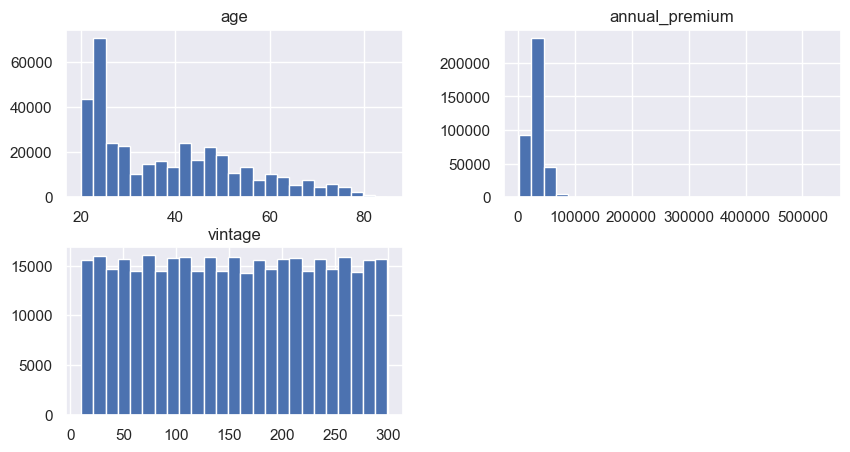

In [54]:
num_attributes.hist(bins=25, figsize = (10, 5 ));

In [55]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


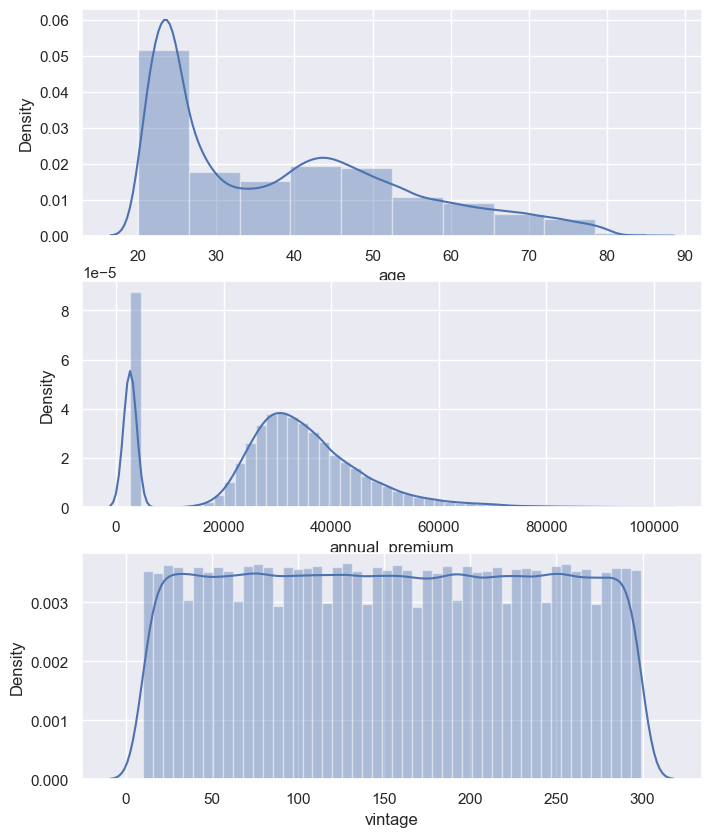

In [56]:
# Looking at the distribuition of the following variables.
fig, axs = plt.subplots(3, figsize = (8, 10))
sns.distplot(df1['age'], ax=axs[0], bins=10)
sns.distplot(df1[df1['annual_premium']<100000]['annual_premium'], ax=axs[1])
sns.distplot(df1['vintage'], ax=axs[2]);

<AxesSubplot: xlabel='vehicle_damage', ylabel='count'>

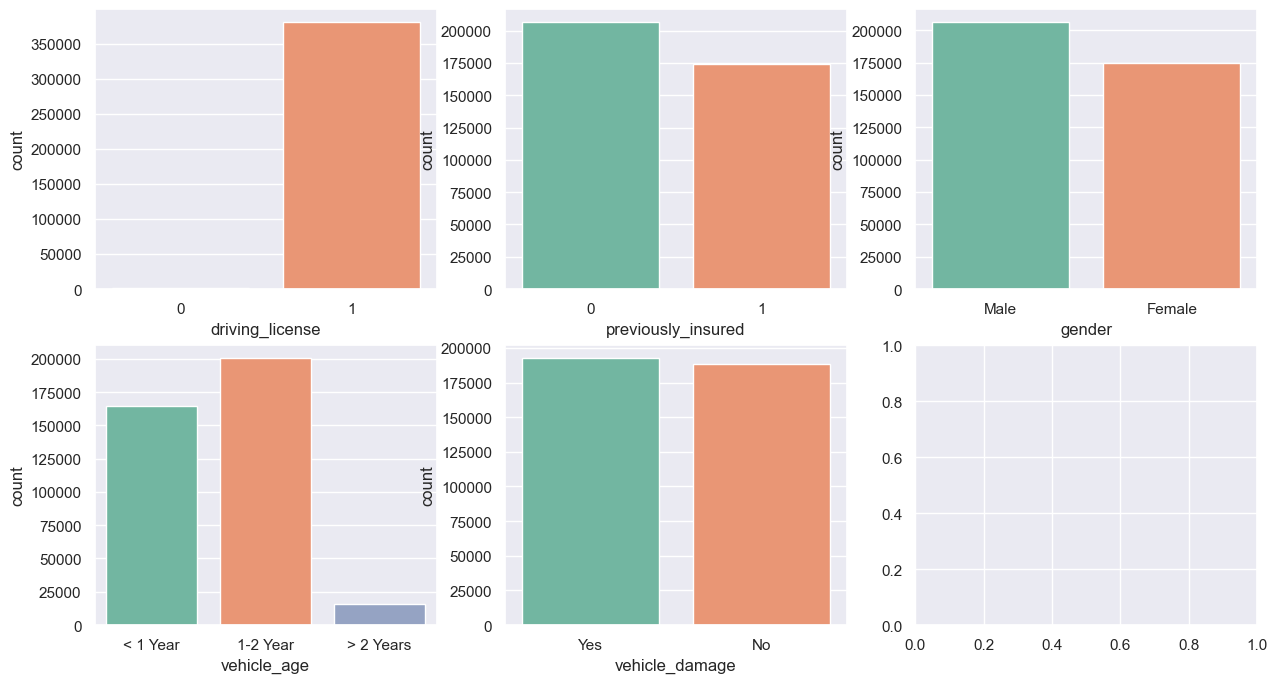

In [57]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize= (15, 8))

sns.countplot(x = 'driving_license', palette = 'Set2', data=df1, ax=axs[0][0])
sns.countplot(x = 'previously_insured', palette = 'Set2', data=df1, ax=axs[0][1])
sns.countplot(x = 'gender', palette = 'Set2', data=df1, ax=axs[0][2])
sns.countplot(x = 'vehicle_age', palette = 'Set2', data=df1, ax=axs[1][0])
sns.countplot(x = 'vehicle_damage', palette = 'Set2', data=df1, ax=axs[1][1])

<AxesSubplot: xlabel='region_code', ylabel='count'>

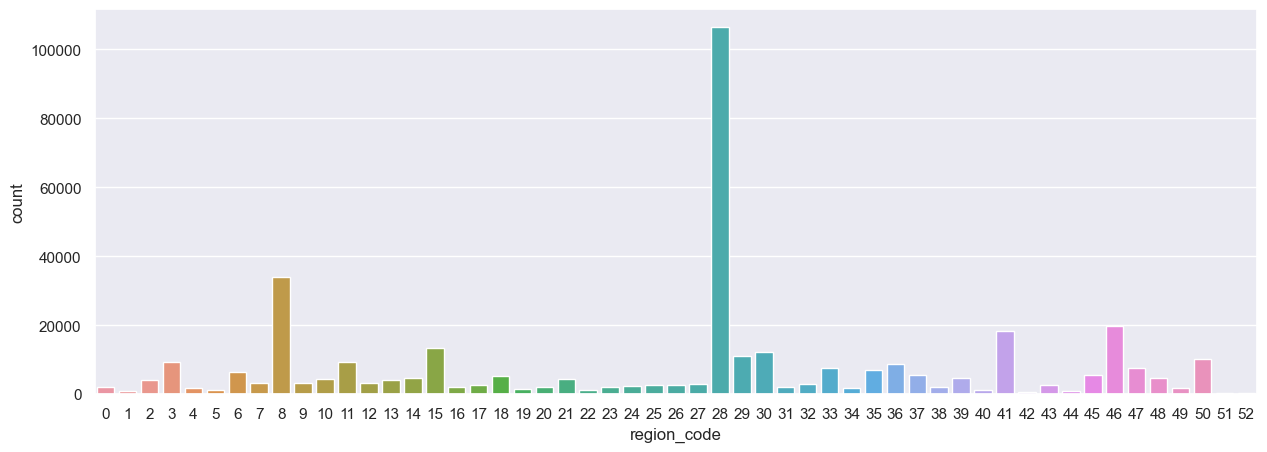

In [58]:
fig = plt.subplots(figsize = (15,5))
sns.countplot(x='region_code', data=df1)

<AxesSubplot: xlabel='policy_sales_channel', ylabel='index'>

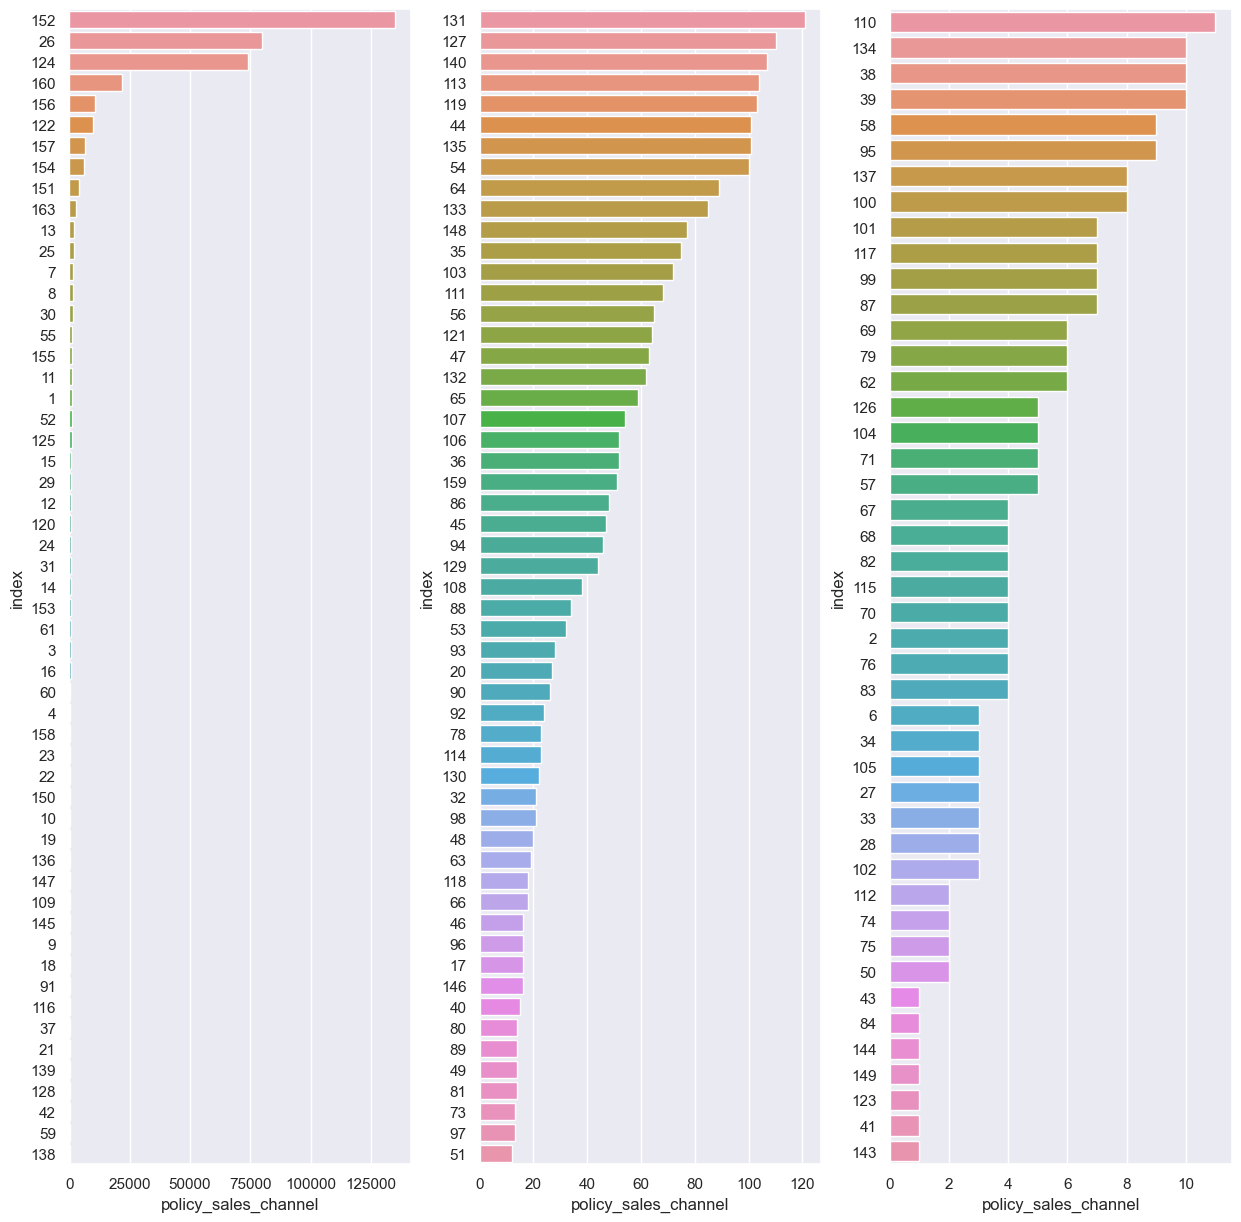

In [59]:
policy_1 = df1['policy_sales_channel'].value_counts().iloc[0:55]
policy_1 = policy_1.reset_index()
policy_2 = df1['policy_sales_channel'].value_counts().iloc[55:110]
policy_2 = policy_2.reset_index()
policy_3 = df1['policy_sales_channel'].value_counts().iloc[110:156]
policy_3 = policy_3.reset_index()

fig, axs = plt.subplots(ncols=3, figsize=(15,15))
sns.barplot(y='index', x='policy_sales_channel', data=policy_1, ax=axs[0], orient='h', order=policy_1['index'])
sns.barplot(y='index', x='policy_sales_channel', data=policy_2, ax=axs[1], orient='h', order=policy_2['index'])
sns.barplot(y='index', x='policy_sales_channel', data=policy_3, ax=axs[2], orient='h', order=policy_3['index'])

## 2 - FEATURE ENGINEERING

In [60]:
df2 = df1.copy()

## 3 - DATA FILTERING

In [61]:
df3 = df2.copy()

## 4 - EXPLORATORY DATA ANALYSIS (EDA)

In [62]:
df4 = df3.copy()

### 4.1 - UNIVARIATE ANALYSIS

ValueError: Could not interpret input 'age_group'

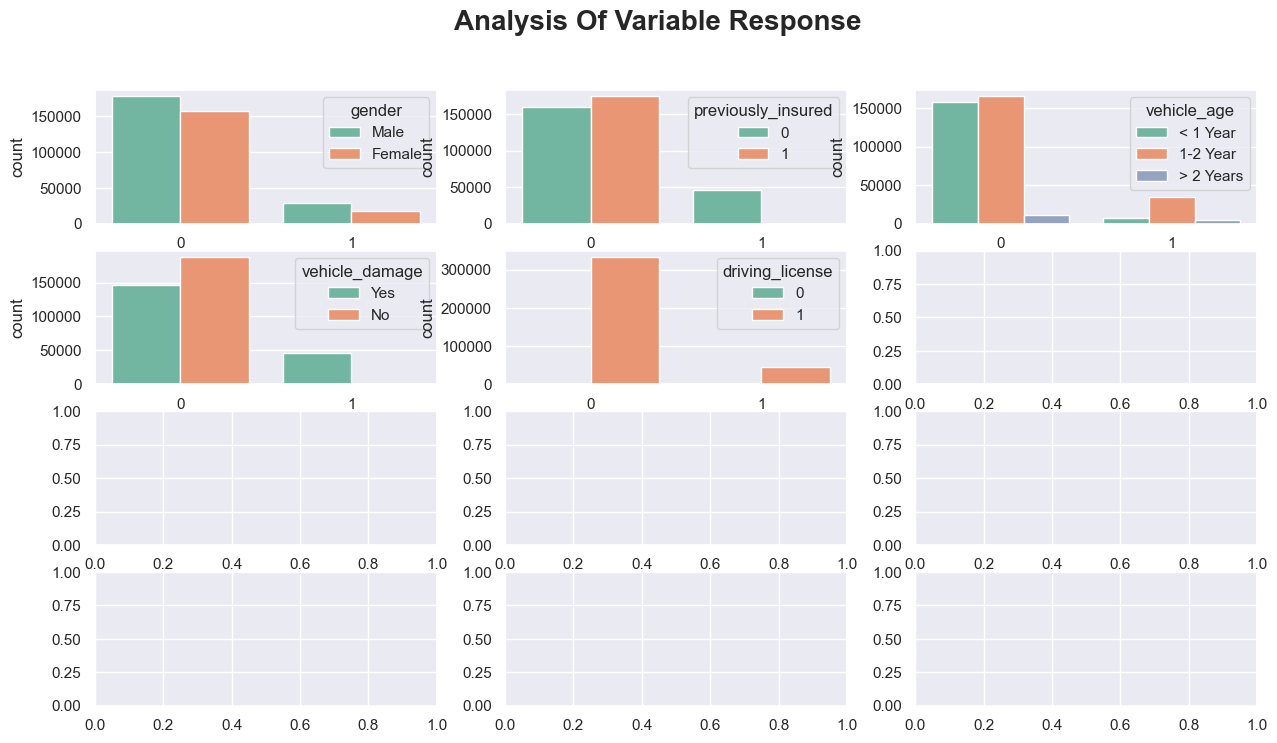

In [63]:
fig, axs = plt.subplots(ncols=3, nrows=4, figsize= (15, 8))

plt.suptitle("Analysis Of Variable Response",fontweight="bold", fontsize=20)

sns.countplot(x = 'response', hue = 'gender', palette = 'Set2', data = df4, ax=axs[0][0])
sns.countplot(x = 'response', hue = 'previously_insured', palette = 'Set2', data = df4, ax=axs[0][1])
sns.countplot(x = 'response', hue = 'vehicle_age', palette = 'Set2', data = df4, ax=axs[0][2])
sns.countplot(x = 'response', hue = 'vehicle_damage', palette = 'Set2', data = df4, ax=axs[1][0])
sns.countplot(x = 'response', hue = 'driving_license', palette = 'Set2', data = df4, ax=axs[1][1])
sns.countplot(x='response', hue = 'age_group', palette = 'Set2', data=df4, ax=axs[1][2])
sns.kdeplot(x='age', hue='response', palette = 'Set2', shade=True, data=df4, ax=axs[2][0])
sns.kdeplot(x='annual_premium', hue='response', palette = 'Set2', shade=True, data=df4, ax=axs[2][1])
sns.kdeplot(x='day_premium', hue='response', palette = 'Set2', shade=True, data=df4, ax=axs[2][2])
sns.kdeplot(x='age_premium', hue='response', palette = 'Set2', shade=True, data=df4, ax=axs[3][0])
sns.kdeplot(x='vintage', hue='response', palette = 'Set2', shade=True, data=df4, ax=axs[3][1])

In [ ]:
# 'policy_sales_channel'

# set the figure size
plt.figure(figsize=(25, 10))

# from raw value to percentage
total = df4.groupby('policy_sales_channel')['id'].count().reset_index()
response_1 = df4.loc[df4.response == 1 ].groupby('policy_sales_channel')['id'].count().reset_index()
response_0 = df4.loc[df4.response == 0 ].groupby('policy_sales_channel')['response'].sum().reset_index()
resp = pd.merge(response_1, response_0, how = 'outer', on = 'policy_sales_channel')
resp['id'] = resp['id'].fillna(0)
resp = resp.sort_values(by='policy_sales_channel')
resp['id'] = [i / j * 100 for i,j in zip(resp['id'], total['id'])]
total['id'] = [i / j * 100 for i,j in zip(total['id'], total['id'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="policy_sales_channel",  y="id", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="policy_sales_channel", y="id", data=resp, color='lightblue')

# add legend
plt.xticks(rotation=90)
top_bar = mpatches.Patch(color='darkblue', label='response = No')
bottom_bar = mpatches.Patch(color='lightblue', label='response = Yes')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

### 4.2 - BIVARIATE ANALYSIS

In [ ]:
#1.The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance. (FALSE)
d1 = df2[( df2['previously_insured'] == 0) & (df2['vehicle_damage'] == 1)]

ax1 = d1.loc[:, 'response'].value_counts()
ax1
# Bar chart
#fig1 = px.bar(ax1, x='response', y='percentage', color='response', text='percentage', height=600)
#fig1.update_traces(texttemplate='%{text:.2s}', textposition='outside')
#fig1.update_layout(title_text="Hypothesis 1: The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance.", title_x=0.45)
#fig1.show()

In [ ]:
#1.The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance. (FALSE)
d1 = df2[( df2['previously_insured'] == 0) & (df2['vehicle_damage'] == 1)]

ax1 = d1[['response','id']].groupby('response').count().reset_index()
ax1['percentage'] = round(ax1['id'] / d1['id'].count()*100)
ax1['response'] = ax1['response'].apply(lambda x: 'No' if (x == 0) else 'Yes')

# Bar chart
fig1 = px.bar(ax1, x='response', y='percentage', color='response', text='percentage', height=600)
fig1.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig1.update_layout(title_text="Hypothesis 1: The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance.", title_x=0.45)
fig1.show()

Hiphotesys is false once 75% of customers doesn't show interest in buying the vehicle insurance. 

In [ ]:
# 2. The interest on purchase the vehicle insurance is greater for woman than men. (FALSE)
ax2 = pd.crosstab(df2['gender'], df2['response'])
ax2['percentage'] = round(ax2[1]/(ax2[0]+ax2[1])*100)

# Creating new dataframe for a bar chart
aux2 = [['Female', 10],['Male',14]]
aux2_df = pd.DataFrame(aux2, columns=['gender','percentage'])

# Bar chart
fig = px.bar(aux2_df, x='gender', y='percentage', color='gender', text='percentage', height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text="Hypothesis 2: The interest on purchase the vehicle insurance is greater for woman than men.", title_x=0.45)
fig.show()


Hiphotesys is false once 14% of the men show interest in buying the vehicle insurance against 10% of women. 

In [ ]:
# 3. The interest on purchase vehicle insurance is greater for vintage customers( 7 months or more )
aux3 = df2[df2['vintage_month'] >= 7 ][['id','response']]
aux4 = df2[df2['vintage_month'] < 7 ][['id','response']]

# Percentage of interested customers that are with the company for more than 7 months
aux18 = aux3[['response','id']].groupby('response').count().reset_index()
aux18['percentage'] = round( aux18['id'] / aux3.shape[0] * 100 )

# Percentage of interested customers that are with the company for less than 7 months
aux19 = aux4[['response','id']].groupby('response').count().reset_index()
aux19['percentage'] = round( aux19['id'] / aux4.shape[0] * 100 )

# Creating new dataframe for a bar chart
ax3 = [['Vintage Customer: 7 months or more', 12],['Vintage Customer: 7 months or less',12]]
ax3_df = pd.DataFrame(ax3, columns=['vintage','percentage'])

# Bar chart
fig = px.bar(ax3_df, x='vintage', y='percentage', color='vintage', text='percentage', height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text="Hypothesis 3: The interest on purchase vehicle insurance is greater for vintage customers( 7 months or more ).", title_x=0.45)
fig.show()

Hiphotesys is false, according the analysis, the period that the customers are with the company doesn't affect the interest in buying vehicle insurance. 

In [ ]:
# 4. The interest on purchase the vehicle insurance is greater for customers that spend less than 30k for annual premium.
aux5 = df2[df2['annual_premium'] > 30000][['id','response']]
aux6 = df2[df2['annual_premium'] <= 30000][['id','response']]

# Percentage of interested customers that spend more than 30k in annual premium
aux16 = aux5[['response','id']].groupby('response').count().reset_index()
aux16['percentage'] = round( aux16['id'] / aux5.shape[0] * 100 )

# Percentage of interested customers that spend less than 30k in annual premium
aux17 = aux6[['response','id']].groupby('response').count().reset_index()
aux17['percentage'] = round( aux17['id'] / aux6.shape[0] * 100 )

# Creating new dataframe for a bar chart
ax4 = [['30k or more in annual premium', 13],['30k or less in annual premium', 11]]
ax4_df = pd.DataFrame(ax4, columns=['annual_premium','percentage'])

# Bar chart
fig = px.bar(ax4_df, x='annual_premium', y='percentage', color='annual_premium', text='percentage', height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text="Hypothesis 4: The interest on purchase the vehicle insurance is greater for customers that spend less than 30k for annual premium.", title_x=0.45)
fig.show()

False, customers that spend more than 30k yearly show greter interest on purchase vehicle insurance.

In [ ]:
# 5. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
aux8 = pd.crosstab(df2['age_group'], df2['response'])
aux8['percentage'] = aux8[1]/(aux8[0]+aux8[1])

# Creating new dataframe for a bar chart
ax5 = [['Young', 3.7],['Adult', 14],['Elder',14]]
ax5_df = pd.DataFrame(ax5, columns=['age_group','percentage'])

# Bar chart
fig = px.bar(ax5_df, x='age_group', y='percentage', color='age_group', text='percentage', height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text="Hypothesis 5: The interest on purchase the vehicle insurance is greater for young customers.", title_x=0.45)
fig.show()

In [ ]:
# 6. The interest on purchase the vehicle insurance is greater for customers that have driver license.
aux9 = pd.crosstab(df2['driving_license'], df2['response'])
aux9['percentage'] = round(aux9[1]/(aux9[0]+aux9[1])*100)

# Creating new dataframe for a bar chart
ax9 = [['No', 5 ],['Yes', 12]]
ax9_df = pd.DataFrame(ax9, columns=['driving_license','percentage'])

# Bar chart
fig = px.bar(ax9_df, x='driving_license', y='percentage', color='driving_license', text='percentage', height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text="Hypothesis 6: The interest on purchase the vehicle insurance is greater for customers that have driver license.", title_x=0.45)
fig.show()

In [ ]:
# 7. The interest on purchase the vehicle insurance is greater for customers that have new cars.
aux10 = pd.crosstab(df2['vehicle_age'], df2['response'])
aux10['percentage'] = round(aux10[1]/(aux10[0]+aux10[1])*100)

# Creating new dataframe for a bar chart
ax10 = [['New', 4 ],['Used', 17],['Old', 29]]
ax10_df = pd.DataFrame(ax10, columns=['vehicle_age','percentage'])

# Bar chart
fig = px.bar(ax10_df, x='vehicle_age', y='percentage', color='vehicle_age', text='percentage', height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text="Hypothesis 7: The interest on purchase the vehicle insurance is greater for customers that have new cars.", title_x=0.45)
fig.show()

In [ ]:
# 8. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
aux11 = df2[(df2['vehicle_damage'] == 1 )]
aux12 = pd.crosstab(aux11['vehicle_age'], aux11['response'])
aux12['percentage'] = round(aux12[1]/(aux12[0]+aux12[1])*100)

# Creating new dataframe for a bar chart
ax11 = [['New', 14 ],['Used', 27],['Old', 29]]
ax11_df = pd.DataFrame(ax11, columns=['vehicle_age','percentage'])

# Bar chart
fig = px.bar(ax11_df, x='vehicle_age', y='percentage', color='vehicle_age', text='percentage', height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text="Hypothesis 8: Interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.", title_x=0.45)
fig.show()

In [ ]:
# 9. The interest on purchase the vehicle insurance is greater for elderly women.
aux13 = df2[(df2['gender'] == 'Female')]
aux14 = pd.crosstab(aux13['age_group'], aux13['response'])
aux14['percentage'] = round(aux14[1]/(aux14[0]+aux14[1])*100)

# Creating new dataframe for a bar chart
ax13 = [['Young', 3 ],['Adult', 13],['Elder', 12]]
ax13_df = pd.DataFrame(ax11, columns=['age_group','percentage'])

# Bar chart
fig = px.bar(ax13_df, x='age_group', y='percentage', color='age_group', text='percentage', height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text="Hypothesis 9: Interest on purchase the vehicle insurance is greater for elderly women.", title_x=0.45)
fig.show()

In [ ]:
# 10. The interest on purchase the vehicle insurance is lower for customers that are already insured.
aux15 = pd.crosstab(df2['previously_insured'], df2['response'])
aux15['percentage'] = round(aux15[1]/(aux15[0]+aux15[1])*100)
aux15

# Creating new dataframe for a bar chart
ax14 = [['No', 23 ],['Yes', 0]] 
ax14_df = pd.DataFrame(ax14, columns=['previously_insured','percentage'])

# Bar chart
fig = px.bar(ax14_df, x='previously_insured', y='percentage', color='previously_insured', text='percentage', height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text="Hypothesis 9: The interest on purchase the vehicle insurance is lower for customers that are already insured.", title_x=0.45)
fig.show()


**Hypothesis Validation**

1. The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance.
    **False, of the customers that damaged their car and doesn't have insurance, only 25% show interest in acquire vehicle insurance.**

2. The interest on purchase the vehicle insurance is greater for woman than men.
    **False, only 10% of women show interest in acquire vehicle insurance, whereas 13% of the men show interest on acquire vehicle insurance.**

3. The interest on purchase vehicle insurance is greater for vintage customers ( 7 months or more ).
    **False, the period that customers are on the company doensn't show influency on interest in buying vehicle insurance.**

4. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, customers that spend more than 30k yearly show greter interest on purchase vehicle insurance.**

5. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, adults and elderlies show greater interest on buying vehicle insurance.**

6. The interest on purchase the vehicle insurance is greater for customers that have driver license.
    **True, arround 12% of customers that hold a driving license show interest in buying the vehicle insurance.**

7. The interest on purchase the vehicle insurance is greater for customers that have new cars.
    **False, the interest is greater for customers that own an old car.**

8. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
    **False, of the customers who damaged their car, the ones that own a old car show greater interest in buying the vehicle insurance (29%), followed by customers that own used cars (27%).**

9. The interest on purchase the vehicle insurance is greater for elderly women.
    **False, adult women show greater interest in buying the vehicle insurance.**

10. The interest on purchase the vehicle insurance is lower for customers that are already insured.
    **True, less than 1% of customers already insured show interest on purchase the vehicle insurance.**


### 4.3 - MULTIVARIATE ANALYSIS

In [ ]:
correlation = df2.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True)

## 5 - DATA PREPARATION

In [6]:
fe_encoder  = CountFrequencyEncoder(variables=['gender', 'vehicle_age', 'vehicle_damage'])

### 5.1 - ML MODELS

In [7]:
# Parameter "scale_pos_weight" definition

from collections import Counter

# ESTIMATE SCALE_POS_WEIGHT
counter = Counter(y_train)
estimate = counter[0]/counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 7.144


#### LGBM

In [8]:
# Model Definition
clf_lgbm = lgbm.LGBMClassifier(scale_pos_weight = estimate )

In [9]:
# Pipeline
model_pipeline_lgbm = pipeline.Pipeline( steps = [("fe_encoder", fe_encoder),
                                                  ("clf_lgbm", clf_lgbm)])

In [10]:
cross_validation(5, 'lgbm', model_pipeline_lgbm, x_train, y_train, 20000)

,lgbm
precision_at_k,0.2686
std_precision,+/-0.0005
recall_at_k,0.9567
std_recall,+/- 0.0019


In [11]:
model_pipeline_lgbm.fit(x_train, y_train)

Pipeline(steps=[('fe_encoder',
                 CountFrequencyEncoder(variables=['gender', 'vehicle_age',
                                                  'vehicle_damage'])),
                ('clf_lgbm',
                 LGBMClassifier(scale_pos_weight=7.143920507158629))])

In [12]:
yhat_lgbm = model_pipeline_lgbm.predict_proba(x_valid)

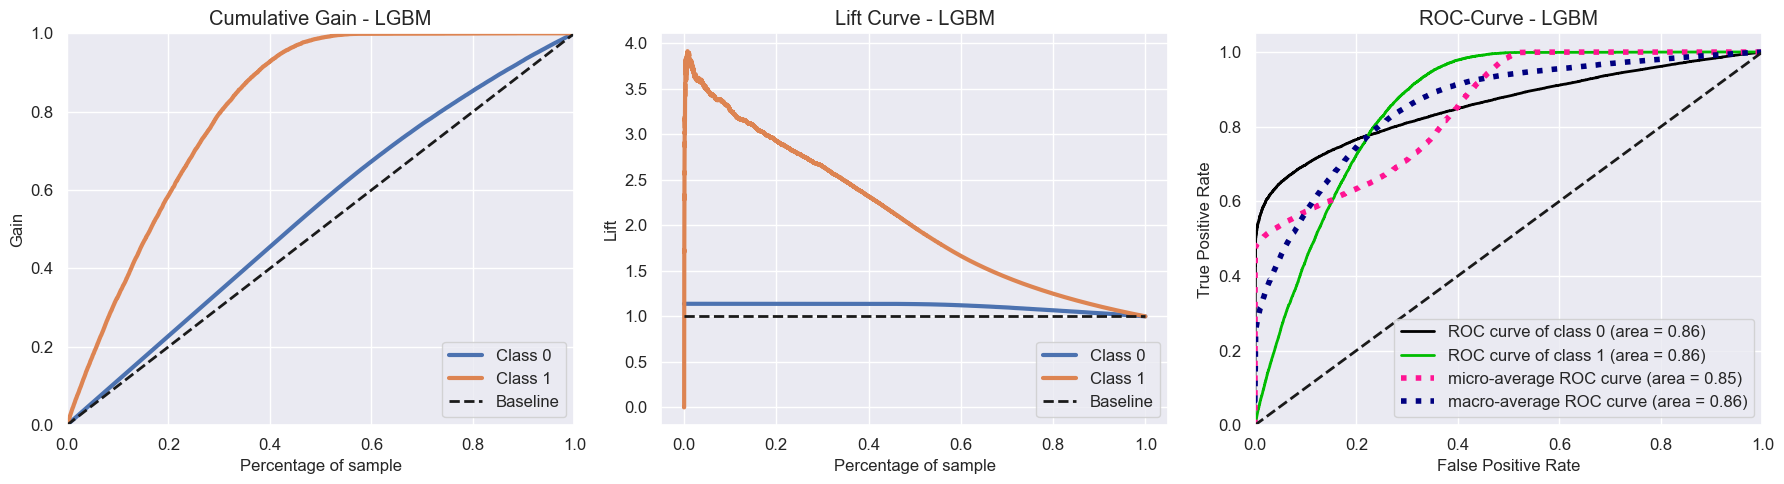

In [13]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_lgbm, ax=axs[0],title='Cumulative Gain - LGBM');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_lgbm,ax=axs[1],title='Lift Curve - LGBM');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_lgbm, ax=axs[2], title='ROC-Curve - LGBM');

plt.tight_layout()

In [14]:
# Precision and Recall @K
# As per Cumulative Gain chart, it is possible to identify that between 40% and 50% the model is able to find all interested customers.
aux = x_valid['id'].count()
k_value = 20000

precision_lgbm = precision_at_k_cv(y_valid, yhat_lgbm, k_value)
recall_lgbm = recall_at_k_cv(y_valid, yhat_lgbm, k_value)
LGBM_performance = ml_performance('LGBM', precision_lgbm, recall_lgbm )
LGBM_performance

,Model Name,Precision_at_K,Recall_at_K
0,LGBM,0.33375,0.721154


#### XGB

In [15]:
# Model Definition
clf_xgb = XGBClassifier(scale_pos_weight = estimate)

In [16]:
# Pipeline
model_pipeline_xgb = pipeline.Pipeline( steps = [("fe_encoder", fe_encoder),
                                                  ("clf_xgb", clf_xgb)])

In [17]:
cross_validation(5, 'xgb', model_pipeline_xgb, x_train, y_train, 20000)

,xgb
precision_at_k,0.2669
std_precision,+/-0.0009
recall_at_k,0.9507
std_recall,+/- 0.0031


In [18]:
model_pipeline_xgb.fit(x_train, y_train)

Pipeline(steps=[('fe_encoder',
                 CountFrequencyEncoder(variables=['gender', 'vehicle_age',
                                                  'vehicle_damage'])),
                ('clf_xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [19]:
yhat_xgb = model_pipeline_xgb.predict_proba(x_valid)

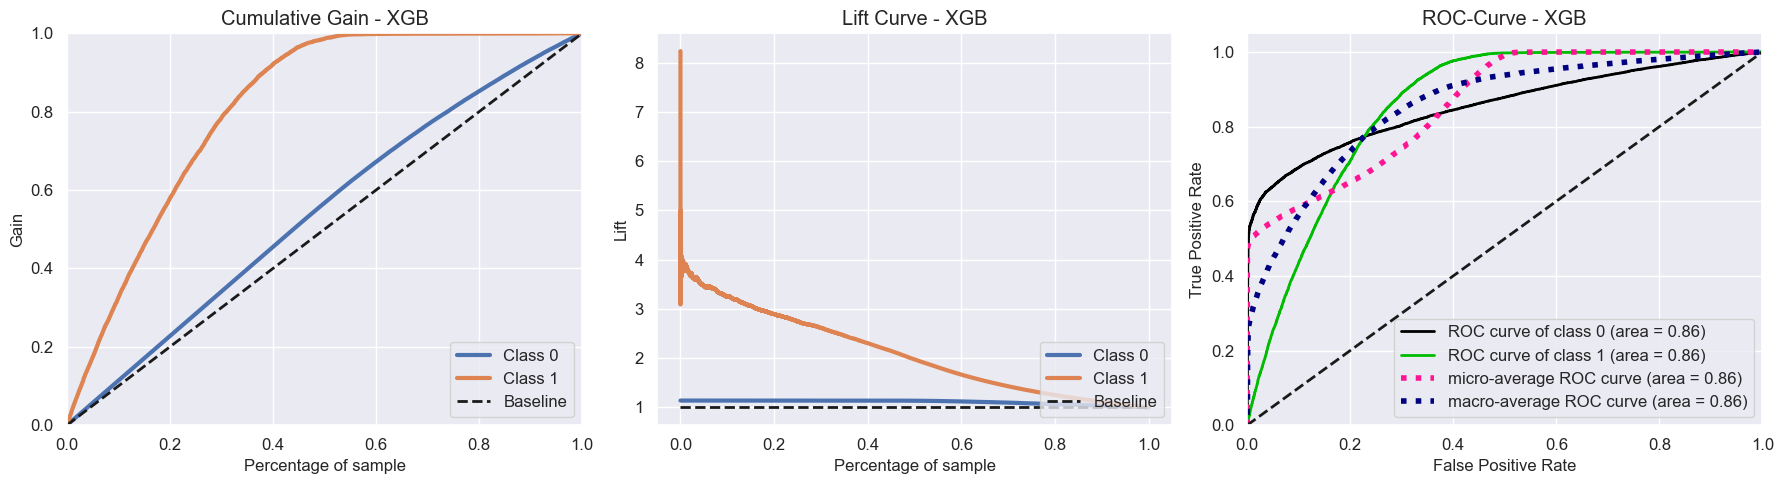

In [20]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_xgb, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_xgb, ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_xgb, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [21]:
# Precision and Recall @K

# As per Cumulative Gain chart, it is possible to identify that between 40% and 50% the model is able to find all interested customers.
aux = x_valid['id'].count()
k_value = 20000


precision_xgb = precision_at_k_cv(y_valid, yhat_xgb, k_value)
recall_xgb = recall_at_k_cv(y_valid, yhat_xgb, k_value)
XGB_performance = ml_performance('XGB', precision_xgb, recall_xgb )
XGB_performance

,Model Name,Precision_at_K,Recall_at_K
0,XGB,0.32855,0.709918


#### KNN

In [22]:
# Model Definition
clf_knn = KNeighborsClassifier( n_neighbors = 8 )

In [23]:
# Pipeline
model_pipeline_knn = pipeline.Pipeline( steps = [("fe_encoder", fe_encoder),
                                                  ("clf_knn", clf_knn)])

In [24]:
cross_validation(5, 'knn', model_pipeline_knn, x_train, y_train, 20000)

,knn
precision_at_k,0.2276
std_precision,+/-0.0011
recall_at_k,0.8108
std_recall,+/- 0.0037


In [25]:
model_pipeline_knn.fit(x_train, y_train)

Pipeline(steps=[('fe_encoder',
                 CountFrequencyEncoder(variables=['gender', 'vehicle_age',
                                                  'vehicle_damage'])),
                ('clf_knn', KNeighborsClassifier(n_neighbors=8))])

In [26]:
yhat_knn = model_pipeline_knn.predict_proba(x_valid)

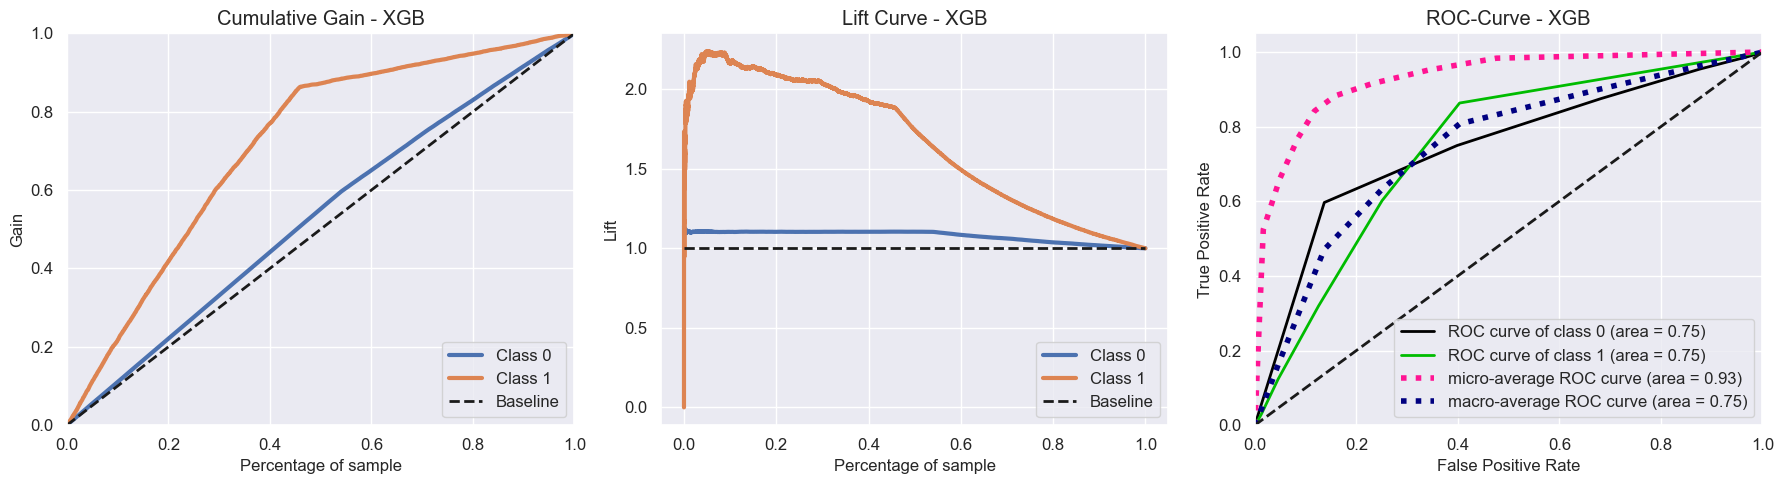

In [27]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_knn, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_knn, ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_knn, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [28]:
# Precision and Recall @K
k_value = 20000


precision_knn = precision_at_k_cv(y_valid, yhat_knn, k_value)
recall_knn = recall_at_k_cv(y_valid, yhat_knn, k_value)
KNN_performance = ml_performance('KNN', precision_knn, recall_knn )
KNN_performance

,Model Name,Precision_at_K,Recall_at_K
0,KNN,0.2494,0.538894


## 9 - HYPERPARAMETER FINE TUNING

### 9.1 - XGB Fine Tuning

In [ ]:
# XGB
def objective_xgb(trial):
    """Define the objective function"""
    params = {
        'clf_xgb__max_depth': trial.suggest_int('clf_xgb__max_depth', 5, 20),
        'clf_xgb__eta': trial.suggest_float('clf_xgb__eta', 0.01, 0.05),
        'clf_xgb__learning_rate': trial.suggest_loguniform('clf_xgb__learning_rate', 0.01, 1.0),
        'clf_xgb__n_estimators': trial.suggest_int('clf_xgb__n_estimators', 100, 1000),
        'clf_xgb__min_child_weight': trial.suggest_int('clf_xgb__min_child_weight', 1, 15),
        'clf_xgb__gamma': trial.suggest_loguniform('clf_xgb__gamma', 1e-8, 1.0),
        'clf_xgb__subsample': trial.suggest_loguniform('clf_xgb__subsample', 0.01, 1.0),
        'clf_xgb__colsample_bytree': trial.suggest_loguniform('clf_xgb__colsample_bytree', 0.1, 1.0),
        'clf_xgb__reg_alpha': trial.suggest_loguniform('clf_xgb__reg_alpha', 1e-8, 1.0),
        'clf_xgb__reg_lambda': trial.suggest_loguniform('clf_xgb__reg_lambda', 1e-8, 1.0),
        'clf_xgb__eval_metric': 'mlogloss'
    }

    # Fit the model
    model_pipeline_xgb.set_params(**params)
    model_pipeline_xgb.fit(x_train, y_train)

    # Make predictions
    optuna_xgb_pred = model_pipeline_xgb.predict_proba(x_valid)

    # Evaluate predictions
    aux = x_valid['id'].count()
    k_value = round(0.4 * aux)
    k_value
    recall_atK = recall_at_k_cv(y_valid, optuna_xgb_pred, k_value)
    return  recall_atK

In [ ]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=2)

In [ ]:
print('Number of finished trials: {}'.format(len(study_xgb.trials)))
print('Best trial:')
trial = study_xgb.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [29]:
param_xgb = {'scale_pos_weight': estimate,
             'max_depth': 6,
             'eta': 0.0310260525237683,
             'learning_rate': 0.03914508739999509,
             'n_estimators': 619,
             'min_child_weight': 9,
             'gamma': 3.06408087126589e-05,
             'subsample': 0.3640515535413122,
             'colsample_bytree': 0.449945653612218,
             'reg_alpha': 0.143727642904309,
             'reg_lambda': 0.020464155005749916
            }

### 9.2 LGBM Fine Tuning

In [ ]:
#LGBM
def objective_lgbm(trial):
    """Objective function"""
    param = {
        "clf_lgbm__n_estimators":trial.suggest_int('clf_lgbm__n_estimators', 100, 1000),
        "clf_lgbm__learning_rate":trial.suggest_float('clf_lgbm__learning_rate', 0.01, 0.1),
        "clf_lgbm__max_depth":trial.suggest_int('clf_lgbm__max_depth', 5, 20),
        "clf_lgbm__objective": "binary",
        "clf_lgbm__metric": "binary_logloss",
        "clf_lgbm__num_leaves": trial.suggest_int("clf_lgbm__num_leaves", 2, 256),
        "clf_lgbm__bagging_fraction": trial.suggest_float("clf_lgbm__bagging_fraction", 0.4, 1.0),
    }
    
    # Definicao do Modelo
    model_pipeline_lgbm.set_params(**param)
    
    # Treinamento do Modelo
    model_pipeline_lgbm.fit(x_train, y_train)
    
    # Predicoes do Modelo
    preds = model_pipeline_lgbm.predict_proba(x_valid)
    
    # Evaluate predictions
    aux = x_valid['id'].count()
    k_value = round(0.4 * aux)
    k_value
    recall_atK = recall_at_k_cv(y_valid, preds, k_value)
    return recall_atK

In [ ]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=30)

In [ ]:
print('Number of finished trials: {}'.format(len(study_lgbm.trials)))
print('Best trial:')
trial = study_lgbm.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [30]:
param_lgbm = { 'scale_pos_weight': estimate,
               'n_estimators': 264,
               'learning_rate': 0.05276782714482312,
               'max_depth': 7,
               'num_leaves': 29,
               'bagging_fraction': 0.9931194489202559
}

## 9.3 - ML Models After Tuning

In [31]:
x_lasttrain = pd.concat([x_train, x_valid], axis=0)
y_lasttrain = pd.concat([y_train, y_valid], axis=0)

### XGB After Tuning

In [32]:
# Model Definition
clf_xgb_ft = XGBClassifier(**param_xgb)


In [33]:
# Pipeline
model_pipeline_xgb_ft = pipeline.Pipeline( steps = [("fe_encoder", fe_encoder),
                                                  ("clf_xgb_ft", clf_xgb_ft)])

In [34]:
model_pipeline_xgb_ft.fit(x_lasttrain, y_lasttrain)

Pipeline(steps=[('fe_encoder',
                 CountFrequencyEncoder(variables=['gender', 'vehicle_age',
                                                  'vehicle_damage'])),
                ('clf_xgb_ft',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.449945653612218,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.0310260525237683,
                               eval_metric=None,...
                               gamma=3.06408087126589e-05, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.03914508739999509, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=9, missing=nan,
                               monotone_constraints=None, n_estimators=619,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [35]:
yhat_xgb_ft = model_pipeline_xgb_ft.predict_proba(x_test)

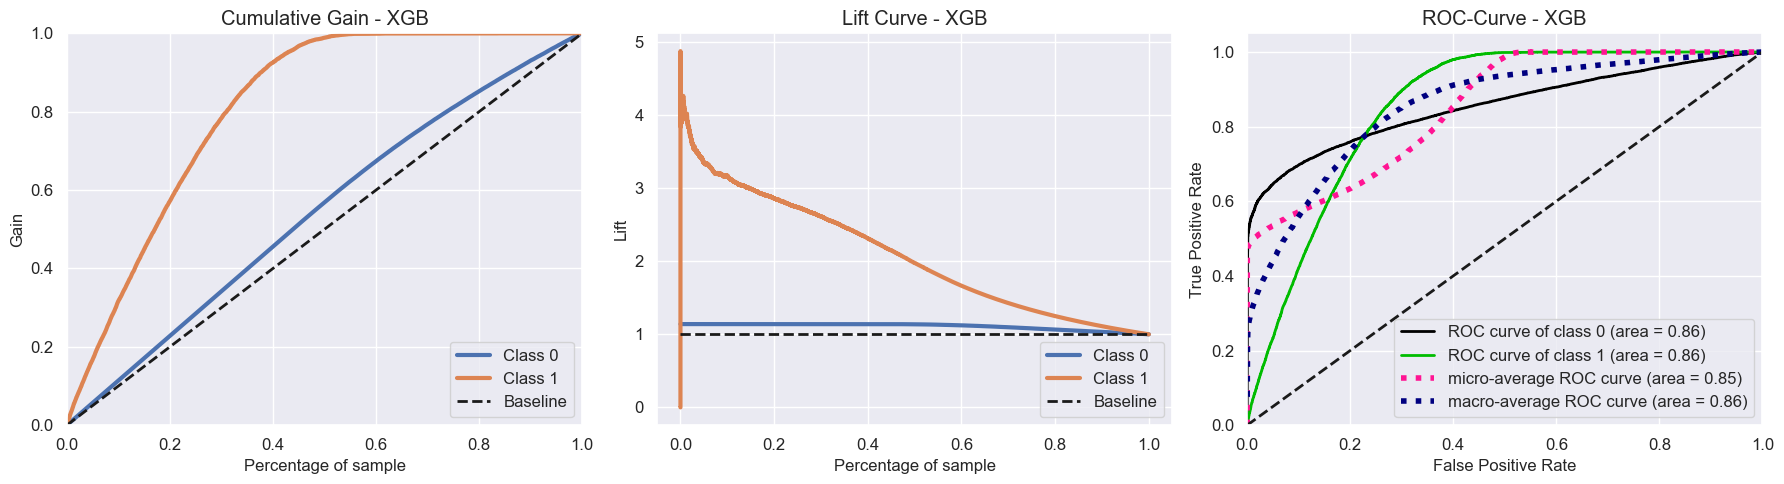

In [36]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb_ft, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_test, yhat_xgb_ft,ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_test, yhat_xgb_ft, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [37]:
# Precision and Recall @K
k_value = 20000


precision_xgb_ft = precision_at_k_cv(y_test, yhat_xgb_ft, k_value)
recall_xgb_ft = recall_at_k_cv(y_test, yhat_xgb_ft, k_value)
KNN_performance = ml_performance('XGB FT', precision_xgb_ft, recall_xgb_ft )
KNN_performance

,Model Name,Precision_at_K,Recall_at_K
0,XGB FT,0.33365,0.711711


In [38]:
# Precision and Recall @K
cross_validation(5, 'xgb_tuned', model_pipeline_xgb_ft, x_lasttrain, y_lasttrain, 20000)

,xgb_tuned
precision_at_k,0.311
std_precision,+/-0.002
recall_at_k,0.8332
std_recall,+/- 0.0053


### LGBM after Tuning

In [39]:
# Model Definition
clf_lgbm_ft = lgbm.LGBMClassifier(**param_lgbm )

In [40]:
# Pipeline for data pre-processing
model_pipeline_lgbm_ft = pipeline.Pipeline( steps = [("fe_encoder", fe_encoder),
                                                     ("clf_lgbm_ft", clf_lgbm_ft)])

In [41]:
# ML Training
model_pipeline_lgbm_ft.fit(x_lasttrain, y_lasttrain)

[LightGBM] [Warning] bagging_fraction is set=0.9931194489202559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9931194489202559


Pipeline(steps=[('fe_encoder',
                 CountFrequencyEncoder(variables=['gender', 'vehicle_age',
                                                  'vehicle_damage'])),
                ('clf_lgbm_ft',
                 LGBMClassifier(bagging_fraction=0.9931194489202559,
                                learning_rate=0.05276782714482312, max_depth=7,
                                n_estimators=264, num_leaves=29,
                                scale_pos_weight=7.143920507158629))])

In [42]:
# ML Predictions
yhat_lgbm_ft = model_pipeline_lgbm_ft.predict_proba(x_test)

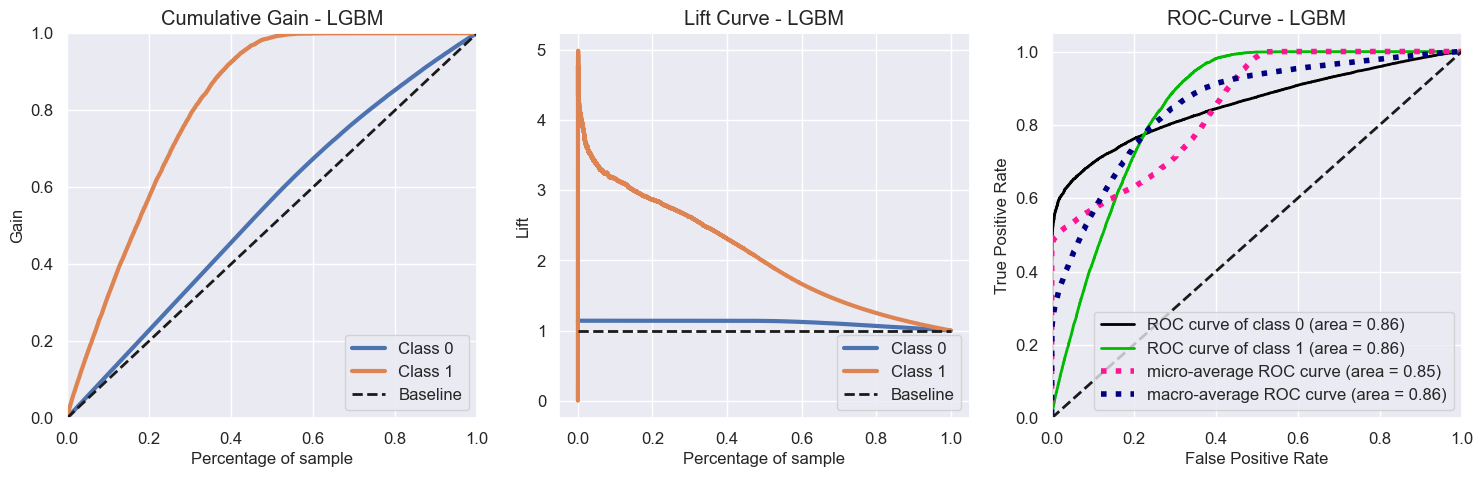

In [43]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_test, yhat_lgbm_ft, ax=axs[0],title='Cumulative Gain - LGBM');

# Lift Curve
skplt.metrics.plot_lift_curve(y_test, yhat_lgbm_ft,ax=axs[1],title='Lift Curve - LGBM');

# Roc Curve
skplt.metrics.plot_roc(y_test, yhat_lgbm_ft, ax=axs[2], title='ROC-Curve - LGBM');


In [44]:
# Precision and Recall @K
k_value = 20000


precision_lgbm_ft = precision_at_k_cv(y_test, yhat_lgbm_ft, k_value)
recall_lgbm_ft = recall_at_k_cv(y_test, yhat_lgbm_ft, k_value)
LGBM_performance_ft = ml_performance('LGBM FT', precision_lgbm_ft, recall_lgbm_ft )
LGBM_performance_ft

,Model Name,Precision_at_K,Recall_at_K
0,LGBM FT,0.33435,0.713204


In [45]:
# Precision and Recall @K
cross_validation(5, 'lgbm_tuned', model_pipeline_lgbm_ft, x_lasttrain, y_lasttrain, 20000)

[LightGBM] [Warning] bagging_fraction is set=0.9931194489202559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9931194489202559
[LightGBM] [Warning] bagging_fraction is set=0.9931194489202559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9931194489202559
[LightGBM] [Warning] bagging_fraction is set=0.9931194489202559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9931194489202559
[LightGBM] [Warning] bagging_fraction is set=0.9931194489202559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9931194489202559
[LightGBM] [Warning] bagging_fraction is set=0.9931194489202559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9931194489202559


,lgbm_tuned
precision_at_k,0.3117
std_precision,+/-0.0016
recall_at_k,0.8351
std_recall,+/- 0.0043


## 10 - DEPLOYING MODEL TO PRODUCTION

### 10.1 - HEALTHINSURANCE CLASS

In [ ]:
import pickle
import inflection
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path                                = ''
        self.frequency_encode_policy_sales_scaler     = pickle.load( open( self.home_path + 'src/features/frequency_encode_policy_sales_scaler.pkl', 'rb') )
        self.frequency_encode_region_code_scaler      = pickle.load( open( self.home_path + 'src/features/frequency_encode_region_code_scaler.pkl', 'rb') )
        self.target_encode_gender_scaler              = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb') )
        self.target_encode_vintage_month_scaler       = pickle.load( open( self.home_path + 'src/features/target_encode_vintage_month_scaler.pkl', 'rb') )
        self.age_scaler                               = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.avg_vehicle_damage_region_code_scaler    = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.avg_vintage_age_scaler                   = pickle.load( open( self.home_path + 'src/features/avg_vintage_age_scaler.pkl', 'rb') )
        self.vintage_scaler                           = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb') )
        self.age_premium_scaler                       = pickle.load( open( self.home_path + 'src/features/age_premium_scaler.pkl', 'rb') )
        self.annual_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/age_premium_scaler.pkl', 'rb') )
        self.avg_day_premium_policy_scaler            = pickle.load( open( self.home_path + 'src/features/avg_day_premium_policy_scaler.pkl', 'rb') )
        self.day_premium_scaler                       = pickle.load( open( self.home_path + 'src/features/day_premium_scaler.pkl', 'rb') )
        self.median_premium_by_region_scaler          = pickle.load( open( self.home_path + 'src/features/median_premium_by_region_scaler.pkl', 'rb') )
        self.region_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/region_premium_scaler.pkl', 'rb') )
    
    def data_cleaning( self, df5 ):
 
        ## rename Columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df5.columns = cols_new
        
        return( df5 )

    def feature_engineering( self, df5 ):
        
        # Fitting vehicle_age column
        df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

        # Fitting vehicle_damage column
        df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)
        
        # median_premium_by_region
        dict_region_code = df5[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
        df5['median_premium_by_region'] = df5['region_code'].map(dict_region_code)

        # moda policy sales chanel por idade
        mode_policy_per_age = df5[['age', 'policy_sales_channel']].groupby('age').agg(pd.Series.mode).to_dict(orient='dict')['policy_sales_channel']
        df5['mode_policy_per_age'] = df5['age'].map(mode_policy_per_age)

        # Media de carros danificados por idade
        avg_carros_danificados_idade = df5[['age', 'vehicle_damage']].groupby('age').mean().to_dict(orient='dict')['vehicle_damage']
        df5['avg_vehicle_damage_per_age'] = df5['age'].map(avg_carros_danificados_idade)

        # Media de carros danificados por regiao
        avg_carros_danificados_regiao = df5[['age', 'region_code']].groupby('age').mean().to_dict(orient='dict')['region_code']
        df5['avg_vehicle_damage_region_code'] = df5['age'].map(avg_carros_danificados_regiao)

        # age_group feature creation
        df5['age_group'] = df5['age'].apply(lambda x: 1 if (x >= 18 | x < 30 ) else 2 if (x >= 30 | x < 60 ) else 3)

        # vintage_month feature cration
        df5['vintage_month'] = round(df5['vintage'] / 31)

        # day_premium feature creation
        df5['day_premium'] = df5['annual_premium']/df5['vintage']

        # age_premium feature cration
        df5['age_premium'] = df5['annual_premium']/df5['age']

        # Calculating Median Annual Premium by Region_code
        premium_rc = df5[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
        df5['region_premium'] = df5['region_code'].map(premium_rc)

        # Calculating Median Aday_premium per policy_sales_channel
        day_premium_psc = df5[['day_premium', 'policy_sales_channel']].groupby('policy_sales_channel').mean().to_dict(orient='dict')['day_premium']
        df5['avg_day_premium_policy'] = df5['policy_sales_channel'].map(day_premium_psc)

        # avg vintage per age
        avg_vintage_per_age = df5[['age', 'vintage']].groupby('age').mean().to_dict(orient='dict')['vintage']
        df5['avg_vintage_age'] = df5['age'].map(avg_vintage_per_age)
        
        return( df5 )
    
    def data_preparation( self, df5 ):
              
        # STANDARDIZATION

        # annual premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # age_premium
        df5['age_premium'] = self.age_premium_scaler.transform( df5[['age_premium']].values )

        # day_premium
        df5['day_premium'] = self.day_premium_scaler.transform( df5[['day_premium']].values )

        # avg_day_premium_policy
        df5['avg_day_premium_policy'] = self.avg_day_premium_policy_scaler.transform( df5[['avg_day_premium_policy']].values )

        # median_premium_by_region
        df5['median_premium_by_region'] = self.median_premium_by_region_scaler.transform( df5[['median_premium_by_region']].values )

        # region_premium
        df5['region_premium'] = self.region_premium_scaler.transform( df5[['region_premium']].values )



        # REESCALING

        # age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # avg_vintage_age
        df5['avg_vintage_age'] = self.avg_vintage_age_scaler.transform( df5[['avg_vintage_age']].values )

        # vintage_month
        df5['vintage_month'] = self.vintage_scaler.transform( df5[['vintage_month']].values )

        # avg_vehicle_damage_region_code
        df5['avg_vehicle_damage_region_code'] = self.avg_vehicle_damage_region_code_scaler.transform( df5[['avg_vehicle_damage_region_code']].values )



        # ENCODER

        # policy sales channel
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.frequency_encode_policy_sales_scaler )

        # region code
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.frequency_encode_region_code_scaler )

        # gender
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # vintage_month
        df5.loc[:, 'vintage_month'] = df5['vintage_month'].map( self.target_encode_vintage_month_scaler )

        # FILL NAN VALUES
        x_valid = x_valid.fillna(0)
        
        # Feature Selection
        cols_selected = ['vehicle_damage','previously_insured','vintage','day_premium','age_premium','annual_premium','vintage_month','region_code','avg_vehicle_damage_per_age','policy_sales_channel','age','median_premium_by_region','region_premium',
                         'avg_day_premium_policy','vehicle_age','avg_vehicle_damage_region_code','avg_vintage_age','gender']
        
        return df5[cols_selected]
    

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )
        
        # join pred into the original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

### 10.2 - API HANDLER

In [ ]:
import pickle
import pandas as pd
import os
from flask                           import Flask, request, Response
from healthinsurance.healthinsurance import HealthInsurance

# logading model
model = pickle.load( open( 'src/models/xgb_model.pkl', 'rb' ) )
                          
# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
               
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
    
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # multiple examples
            
        # Instantiate Rossmann Class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
              
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
                              
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run('0.0.0.0')

#    port = os.environ.get('PORT', 5000)
#    app.run( host='0.0.0.0', port=port )

## 11 - BUSINESS QUESTIONS

In [ ]:
df11 = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/processed/score_V2.csv')

### 1 - What percentage of customers interested in purchasing a car insurance will the sales team be able to contact by making 20,000 calls?

In [ ]:
n = 20000
ax1 = df11['id'][(df11['score'] > 0.5)].count()


print(f'Numbers os contacts: {n} ({n/len(df11):.2%})')
print(f'Will impact {n/ax1:.2%} of interested customers')

In [ ]:
n = 20000
ax1 = df12['id'][(df12['score'] > 0.5)].count()

2
print(f'Numbers os contacts: {n} ({n/len(df12):.2%})')
print(f'Will impact {n/ax1:.2%} of interested customers')

### 2 -  And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing a car insurance will the sales team be able to contact?

In [ ]:
n = 40000
ax1 = df11['id'][(df11['score'] > 0.5)].count()


print(f'Numbers os contacts: {n} ({n/len(df11):.2%})')
print(f'Will impact {n/ax1:.2%} of interested customers')

In [ ]:
n = 40000
ax1 = df12['id'][(df12['score'] > 0.5)].count()


print(f'Numbers os contacts: {n} ({n/len(df12):.2%})')
print(f'Will impact {n/ax1:.2%} of interested customers')

### 3 - How many calls does the sales team need to make to contact 80% of customers interested in purchasing a car insurance?

In [ ]:
ax1 = df11['id'][(df11['score'] > 0.5)].count()
x = 0.8
n = ax1 * x

print(f'Numbers os contacts: {n} ({n/len(df11):.2%})')

In [ ]:
ax1 = df12['id'][(df12['score'] > 0.5)].count()
x = 0.8
n = ax1 * x

print(f'Numbers os contacts: {n} ({n/len(df12):.2%})')